# Field interpolation

Working with complex magnet shapes can be cumbersome when a lot of base shapes are required, see {ref}`examples-complex-forms`. One way around this problem is to compute the field only a single time on a 3D grid, define an interpolation function, and use the interpolation function as `field_func` input of a custom source.

This makes it possible to use the full Magpylib geometry interface, to move/rotate the complex source around, without having to recompute the total field at new observer positions. Of course this method would also allow it to integrate the field from a **finite element** computation or some **experimental data** into Magpylib.

In the following example we show how this can be done. To improve readability, this example is constructed in the form of a Jupyter notebook.

## Interpolation function

We start by defining a 3D vector-field interpolation function relying on the scipy `RegularGridInterpolator` functionality.

In [1]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import magpylib as magpy

def interpolate_field(data, method="linear", bounds_error=False, fill_value=np.nan):
    """ Creates a 3D-vector field interpolation from regular grid data

    Parameters
    ----------
    data: array_like, shape (n,6)
        The first dimension is a flattened regular grid, the second
        dimension corresponds to positions x, y, z, then field Bx, By, Bz
        in this order.

    method : str, optional
        The method of interpolation to perform. Supported are "linear" and
        "nearest". Default is "linear".

    bounds_error : bool, optional
        If True, when interpolated values are requested outside of the
        domain of the input data, a ValueError is raised. If False,
        then `fill_value` is returned.

    fill_value : number, optional
        Value returned when points outside the interpolation domain are
        sampled.

    Returns
    -------
        callable: interpolating function for field values
    """
    # condition input data
    data = np.array(data)
    idx = np.lexsort((data[:, 2], data[:, 1], data[:, 0]))  # sort data by x,y,z
    x, y, z, *field_vec = data[idx].T
    X, Y, Z = np.unique(x), np.unique(y), np.unique(z)
    nx, ny, nz = len(X), len(Y), len(Z)

    # construct interpolation with RegularGridInterpolator
    field_interp = []
    kwargs = dict(bounds_error=bounds_error, fill_value=fill_value, method=method)
    for f in field_vec:
        rgi = RegularGridInterpolator((X, Y, Z), f.reshape(nx, ny, nz), **kwargs)
        field_interp.append(rgi)

    def field_func(field, observers):
        return np.array([f(observers) for f in field_interp]).T
    return field_func

## Custom source with interpolation field

In the second step we create a custom source with an interpolated field as `get_B_lambda` input. In this example, the data for the interpolation is generated from a known cuboid field, which makes it easy to verify this approach afterwards.

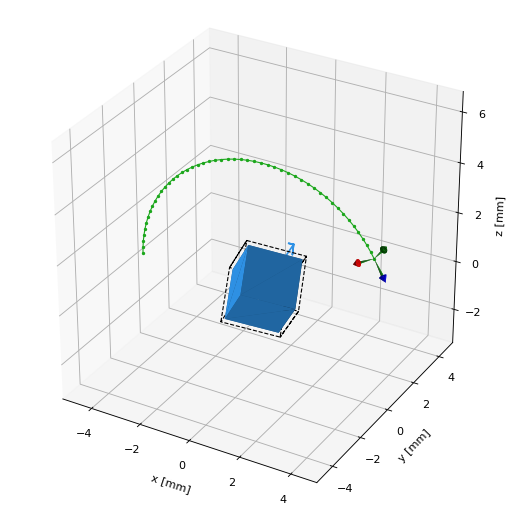

In [2]:
# create data for interpolation
cube = magpy.magnet.Cuboid(magnetization=(0,0,1000), dimension=(2,2,2))
ts = np.linspace(-7, 7, 21)
grid = np.array(np.meshgrid(ts,ts,ts)).T.reshape(-1,3)
data = np.hstack((grid, cube.getB(grid)))

# create custom source with nice 3D model
custom = magpy.misc.CustomSource(field_func=interpolate_field(data))

xs = 1.1*np.array([-1, -1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1, 1,  1, -1])
ys = 1.1*np.array([-1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1])
zs = 1.1*np.array([-1, -1, -1, -1, -1,  1,  1, -1,  1,  1, -1,  1,  1, -1,  1,  1])

trace = dict(
    backend='matplotlib',
    constructor='plot',
    args=(xs, ys, zs),
    kwargs={'ls':'--', 'marker':'', 'lw':1, 'color':'k'},
)
custom.style.model3d.add_trace(trace)
custom.style.model3d.showdefault=False

# apply some geometric manipulation
for src in [cube, custom]:
    src.rotate_from_angax(angle=45, axis=(1,1,1))

# add a sensor for testing
sensor = magpy.Sensor(position=(-5,0,0))
angs = np.linspace(3,150,49)
sensor.rotate_from_angax(angle=angs, axis='y', anchor=0)

magpy.show(cube, custom, sensor)

## Testing the accuracy of the interpolation

Finally, we compare the "exact" field of the cuboid source with the interpolated field of the custom source. Naturally there is some error that can be reduced by increasing the interpolation grid finesse.

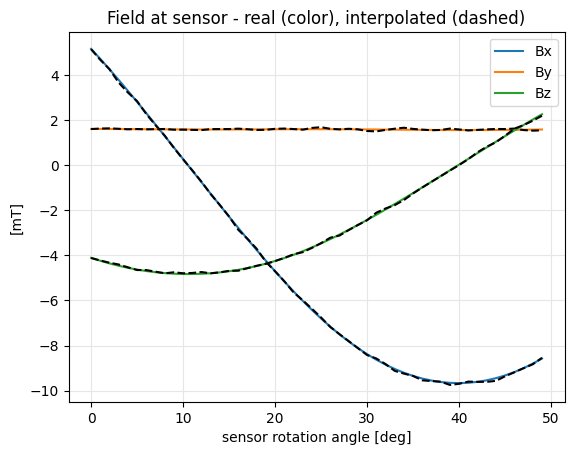

In [3]:
import matplotlib.pyplot as plt

# compute and plot fields
B_cube = cube.getB(sensor)
B_custom = custom.getB(sensor)
for i,lab in enumerate(['Bx', 'By', 'Bz']):
    plt.plot(B_cube[:,i], label=lab)
    plt.plot(B_custom[:,i], ls='--', color='k')

# Matplotlib figure styling
plt.legend()
plt.grid(color='.9')
plt.gca().set(
    title='Field at sensor - real (color), interpolated (dashed)',
    xlabel='sensor rotation angle [deg]',
    ylabel='[mT]',
)

plt.show()